# Xây dựng & Huấn luyện Mô hình (Modeling)

Notebook này thực hiện:
1. Tải dữ liệu đã tiền xử lý từ `train.csv` và `test.csv`
2. Huấn luyện 3 mô hình phân loại: **Logistic Regression**, **Naive Bayes**, **K-Nearest Neighbors**
3. Đánh giá và so sánh các mô hình theo các metric: **Accuracy**, **Precision**, **Recall**, **F1-Score**
4. Rút ra kết luận về mô hình tốt nhất

## 1. Thiết lập môi trường và import thư viện

---

## Lý thuyết thuật toán

### 1.1. Logistic Regression

**Công thức toán học:**

Logistic Regression sử dụng hàm sigmoid để ánh xạ tổ hợp tuyến tính của features về xác suất trong khoảng (0, 1):

$$
h_\theta(x) = \sigma(z) = \frac{1}{1 + e^{-z}}
$$

trong đó $z = \theta^T x = \theta_0 + \theta_1 x_1 + ... + \theta_n x_n$

**Hàm mất mát (Binary Cross-Entropy):**

$$
J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} [y^{(i)} \log(h_\theta(x^{(i)})) + (1-y^{(i)}) \log(1-h_\theta(x^{(i)}))] + \frac{\lambda}{2m} \sum_{j=1}^{n} \theta_j^2
$$

**Gradient Descent:**

$$
\theta_j := \theta_j - \alpha \frac{\partial J}{\partial \theta_j}
$$

$$
\frac{\partial J}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)} + \frac{\lambda}{m}\theta_j
$$

**Cách implement bằng NumPy:**
- Sử dụng `np.exp()` và phép chia để tính hàm sigmoid
- Vector hóa phép tính gradient: `grad = X.T @ (predictions - y) / m`
- Cập nhật weights: `theta -= learning_rate * grad`
- L2 regularization: thêm `lambda * theta / m` vào gradient (không regularize bias term)

---

### 1.2. Gaussian Naive Bayes

**Định lý Bayes:**

$$
P(C_k | x) = \frac{P(x | C_k) P(C_k)}{P(x)}
$$

Với giả định các features độc lập có điều kiện:

$$
P(x_1, ..., x_n | C_k) = \prod_{i=1}^{n} P(x_i | C_k)
$$

**Gaussian (Normal) Distribution:**

$$
P(x_i | C_k) = \frac{1}{\sqrt{2\pi\sigma_{k,i}^2}} \exp\left(-\frac{(x_i - \mu_{k,i})^2}{2\sigma_{k,i}^2}\right)
$$

**Log-likelihood (để tránh underflow):**

$$
\log P(C_k | x) = \log P(C_k) + \sum_{i=1}^{n} \log P(x_i | C_k)
$$

$$
\log P(x_i | C_k) = -\frac{1}{2}\log(2\pi\sigma_{k,i}^2) - \frac{(x_i - \mu_{k,i})^2}{2\sigma_{k,i}^2}
$$

**Cách implement bằng NumPy:**
- Tính mean và variance cho mỗi feature theo từng class: `X[y==c].mean(axis=0)`, `X[y==c].var(axis=0)`
- Tính prior: `np.bincount(y) / len(y)`
- Tính log-likelihood vector hóa: `log_prob = -0.5 * np.sum(np.log(2*np.pi*var)) - 0.5 * np.sum((X - mean)**2 / var, axis=1)`
- Normalize xác suất bằng log-sum-exp trick: `probs = np.exp(log_probs - logsumexp)`

---

### 1.3. K-Nearest Neighbors (KNN)

**Khoảng cách Euclidean:**

$$
d(x, x') = \sqrt{\sum_{i=1}^{n} (x_i - x'_i)^2}
$$

**Quy tắc phân loại (Uniform weights):**

$$
\hat{y} = \text{mode}\\{y_1, y_2, ..., y_k\\}
$$

trong đó $y_1, ..., y_k$ là nhãn của k láng giềng gần nhất.

**Distance-weighted voting:**

$$
\hat{y} = \arg\max_{c} \sum_{i=1}^{k} w_i \cdot \mathbb{1}(y_i = c)
$$

với $w_i = \frac{1}{d(x, x_i) + \epsilon}$

**Cách implement bằng NumPy:**
- Tính khoảng cách: `distances = np.sqrt(np.sum((X_train - x)**2, axis=1))`
- Tìm k láng giềng: `k_indices = np.argsort(distances)[:k]`
- Vote đơn giản: `prediction = np.bincount(y_train[k_indices]).argmax()`
- Distance-weighted: tính trọng số `weights = 1 / (distances[k_indices] + 1e-9)` và tổng trọng số theo class

---

In [13]:
import os
import sys
import numpy as np
import time

# Thiết lập đường dẫn để import module src
repo_root = os.getcwd()
if os.path.basename(repo_root) == 'notebooks':
    repo_root = os.path.dirname(repo_root)
if repo_root not in sys.path:
    sys.path.append(repo_root)

from src.models import (
    LogisticRegressionNumpy,
    GaussianNaiveBayesNumpy,
    KNeighborsClassifierNumpy,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

print('Đã import thành công các module!')

Đã import thành công các module!


## 2. Tải dữ liệu đã tiền xử lý

In [ ]:
# Đọc dữ liệu train và test đã tiền xử lý
train_path = os.path.join(repo_root, 'data', 'processed', 'train.csv')
test_path = os.path.join(repo_root, 'data', 'processed', 'test.csv')

# Đọc dữ liệu (bỏ qua dòng header)
train_data = np.loadtxt(train_path, delimiter=',', skiprows=1)
test_data = np.loadtxt(test_path, delimiter=',', skiprows=1)

# Tách features và labels
X_train = train_data[:, :-1]
y_train = train_data[:, -1].astype(int)

X_test = test_data[:, :-1]
y_test = test_data[:, -1].astype(int)

print(f'Train set: X_train shape = {X_train.shape}, y_train shape = {y_train.shape}')
print(f'Test set: X_test shape = {X_test.shape}, y_test shape = {y_test.shape}')
print(f'\nPhân bố nhãn trong tập train: {np.bincount(y_train)}')
print(f'Phân bố nhãn trong tập test: {np.bincount(y_test)}')

Train set: X_train shape = (13588, 22), y_train shape = (13588,)
Test set: X_test shape = (2026, 22), y_test shape = (2026,)

Phân bố nhãn trong tập train: [6794 6794]
Phân bố nhãn trong tập test: [1706  320]


## 3. Huấn luyện các mô hình

### 3.1. Logistic Regression

In [15]:
# Khởi tạo và huấn luyện
start_time = time.time()
lr_model = LogisticRegressionNumpy(
    lr=0.1,
    n_iters=1000,
    l2=0.01,
    fit_intercept=True,
    random_state=42
)
lr_model.fit(X_train, y_train)
train_time = time.time() - start_time

# predict
y_pred_train = lr_model.predict(X_train)
y_pred_test = lr_model.predict(X_test)


print(f"\nThời gian huấn luyện: {train_time:.2f}s")
print(f"Accuracy:  {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Precision: {precision_score(y_train, y_pred_train):.4f}")
print(f"Recall:    {recall_score(y_train, y_pred_train):.4f}")
print(f"F1-Score:  {f1_score(y_train, y_pred_train):.4f}")

print(f"Kết quả trên tập test")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_test):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_test):.4f}")


Thời gian huấn luyện: 0.21s
Accuracy:  0.8487
Precision: 0.8488
Recall:    0.8485
F1-Score:  0.8487
Kết quả trên tập test
Accuracy:  0.8421
Precision: 0.5000
Recall:    0.8656
F1-Score:  0.6339


### 3.2. Gaussian Naive Bayes

In [16]:
start_time = time.time()
nb_model = GaussianNaiveBayesNumpy()
nb_model.fit(X_train, y_train)
train_time = time.time() - start_time

y_pred_train = nb_model.predict(X_train)
y_pred_test = nb_model.predict(X_test)

print(f"Thời gian huấn luyện: {train_time:.2f}s")
print(f"Accuracy:  {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Precision: {precision_score(y_train, y_pred_train):.4f}")
print(f"Recall:    {recall_score(y_train, y_pred_train):.4f}")
print(f"F1-Score:  {f1_score(y_train, y_pred_train):.4f}")

print(f"Kết quả trên tập test")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_test):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_test):.4f}")

Thời gian huấn luyện: 0.00s
Accuracy:  0.8056
Precision: 0.7942
Recall:    0.8250
F1-Score:  0.8093
Kết quả trên tập test
Accuracy:  0.7932
Precision: 0.4203
Recall:    0.8156
F1-Score:  0.5547


### 3.3. KNN

In [17]:
start_time = time.time()
knn_model = KNeighborsClassifierNumpy(
    n_neighbors=5,
    weights='uniform'
)
knn_model.fit(X_train, y_train)
train_time = time.time() - start_time

# print(f"\nThời gian huấn luyện: {train_time:.2f}s")  lazy learning =))
start_pred = time.time()
y_pred_train = knn_model.predict(X_train)
print(f"Thời gian dự đoán train {time.time() - start_pred:.2f}s")

start_pred = time.time()
y_pred_test = knn_model.predict(X_test)
print(f"Hoàn tất dự đoán test trong {time.time() - start_pred:.2f}s")


print(f"\n--- Kết quả trên tập TRAIN ---")
print(f"Accuracy:  {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Precision: {precision_score(y_train, y_pred_train):.4f}")
print(f"Recall:    {recall_score(y_train, y_pred_train):.4f}")
print(f"F1-Score:  {f1_score(y_train, y_pred_train):.4f}")

print(f"\n--- Kết quả trên tập TEST ---")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_test):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_test):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_test):.4f}")

Thời gian dự đoán train 21.87s
Hoàn tất dự đoán test trong 3.17s

--- Kết quả trên tập TRAIN ---
Accuracy:  0.9542
Precision: 0.9200
Recall:    0.9950
F1-Score:  0.9560

--- Kết quả trên tập TEST ---
Accuracy:  0.8667
Precision: 0.5534
Recall:    0.8094
F1-Score:  0.6574


## 4. So sánh các mô hình

Tổng hợp kết quả của cả 3 mô hình để dễ dàng so sánh.

In [18]:
models_results = {
    'Logistic Regression': {
        'model': lr_model,
        'train_preds': lr_model.predict(X_train),
        'test_preds': lr_model.predict(X_test)
    },
    'Naive Bayes': {
        'model': nb_model,
        'train_preds': nb_model.predict(X_train),
        'test_preds': nb_model.predict(X_test)
    },
    'KNN (k=5)': {
        'model': knn_model,
        'train_preds': knn_model.predict(X_train),
        'test_preds': knn_model.predict(X_test)
    }
}

# Tạo bảng so sánh
print("BẢNG SO SÁNH KẾT QUẢ CÁC MÔ HÌNH TRÊN TẬP TEST")
print(f"{'Model':<25} {'Accuracy':>12} {'Precision':>12} {'Recall':>12} {'F1-Score':>12}")
print("-" * 90)

for model_name, results in models_results.items():
    y_pred = results['test_preds']
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"{model_name:<25} {acc:>12.4f} {prec:>12.4f} {rec:>12.4f} {f1:>12.4f}")


BẢNG SO SÁNH KẾT QUẢ CÁC MÔ HÌNH TRÊN TẬP TEST
Model                         Accuracy    Precision       Recall     F1-Score
------------------------------------------------------------------------------------------
Logistic Regression             0.8421       0.5000       0.8656       0.6339
Naive Bayes                     0.7932       0.4203       0.8156       0.5547
KNN (k=5)                       0.8667       0.5534       0.8094       0.6574


In [19]:
# Tìm mô hình tốt nhất theo từng metric
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metric_funcs = [accuracy_score, precision_score, recall_score, f1_score]

print("MÔ HÌNH TỐT NHẤT THEO TỪNG METRIC")

for metric_name, metric_func in zip(metrics, metric_funcs):
    best_model = None
    best_score = -1
    
    for model_name, results in models_results.items():
        score = metric_func(y_test, results['test_preds'])
        if score > best_score:
            best_score = score
            best_model = model_name
    
    print(f"{metric_name:<15}: {best_model:<25} ({best_score:.4f})")

MÔ HÌNH TỐT NHẤT THEO TỪNG METRIC
Accuracy       : KNN (k=5)                 (0.8667)
Precision      : KNN (k=5)                 (0.5534)
Recall         : Logistic Regression       (0.8656)
F1-Score       : KNN (k=5)                 (0.6574)


## 5. Phân tích chi tiết và Confusion Matrix

In [ ]:
def confusion_matrix(y_true, y_pred):
    """Tính confusion matrix cho bài toán nhị phân."""
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tp = np.sum((y_true == 1) & (y_pred == 1))
    return np.array([[tn, fp], [fn, tp]])


print("CONFUSION MATRIX CHO TỪNG MÔ HÌNH (trên tập TEST)")

for model_name, results in models_results.items():
    cm = confusion_matrix(y_test, results['test_preds'])
    print(f"\n{model_name}:")
    print(f"                 Predicted")
    print(f"                 Neg    Pos")
    print(f"Actual  Neg  [{cm[0,0]:6d} {cm[0,1]:6d}]")
    print(f"        Pos  [{cm[1,0]:6d} {cm[1,1]:6d}]")
    # print(f"\nTrue Negatives:  {cm[0,0]:6d}  |  False Positives: {cm[0,1]:6d}")
    # print(f"False Negatives: {cm[1,0]:6d}  |  True Positives:  {cm[1,1]:6d}")
    print("-" * 90)

CONFUSION MATRIX CHO TỪNG MÔ HÌNH (trên tập TEST)

Logistic Regression:
                 Predicted
                 Neg    Pos
Actual  Neg  [  1429    277]
        Pos  [    43    277]
------------------------------------------------------------------------------------------

Naive Bayes:
                 Predicted
                 Neg    Pos
Actual  Neg  [  1346    360]
        Pos  [    59    261]
------------------------------------------------------------------------------------------

KNN (k=5):
                 Predicted
                 Neg    Pos
Actual  Neg  [  1497    209]
        Pos  [    61    259]
------------------------------------------------------------------------------------------


## 5.2. Trực quan hóa kết quả

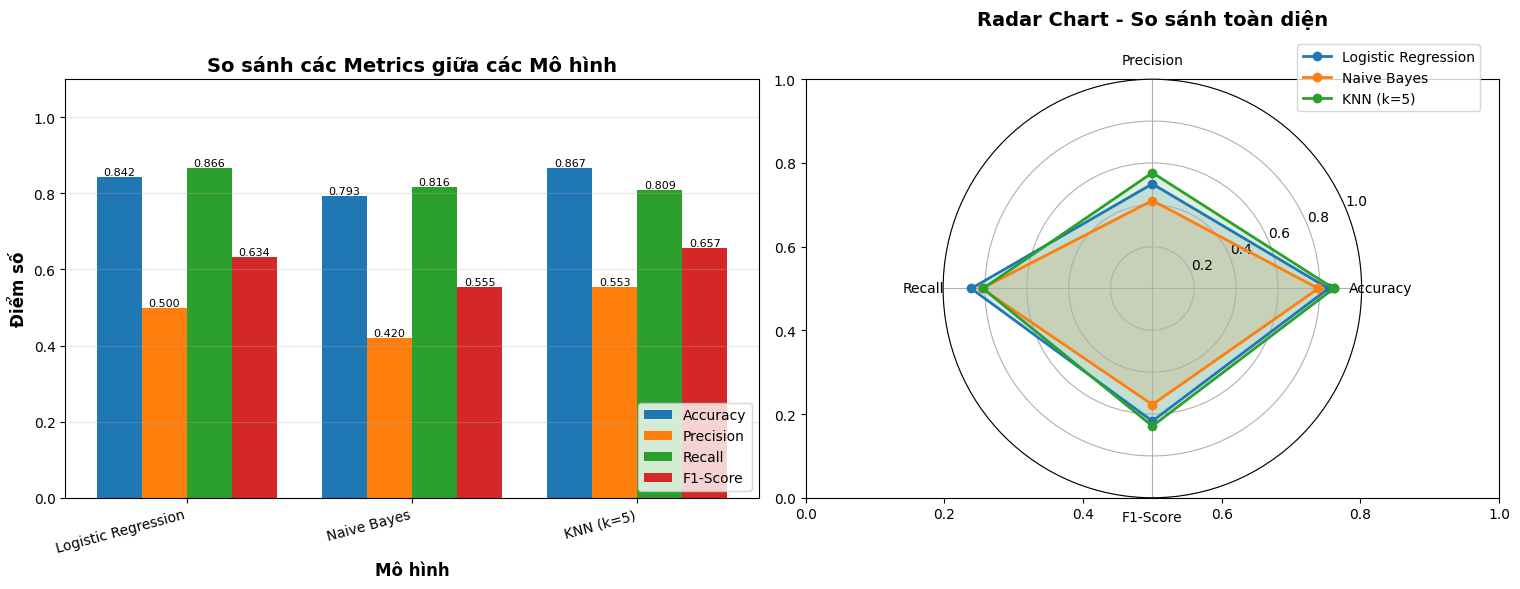

In [25]:
# Tạo biểu đồ so sánh các metrics
import matplotlib.pyplot as plt

# Thu thập metrics cho tất cả các models
model_names = list(models_results.keys())
metrics_dict = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

for model_name in model_names:
    y_pred = models_results[model_name]['test_preds']
    metrics_dict['Accuracy'].append(accuracy_score(y_test, y_pred))
    metrics_dict['Precision'].append(precision_score(y_test, y_pred))
    metrics_dict['Recall'].append(recall_score(y_test, y_pred))
    metrics_dict['F1-Score'].append(f1_score(y_test, y_pred))

# Tạo figure với 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Biểu đồ cột so sánh các metrics
x = np.arange(len(model_names))
width = 0.2

for i, (metric_name, values) in enumerate(metrics_dict.items()):
    offset = width * (i - 1.5)
    bars = ax1.bar(x + offset, values, width, label=metric_name)
    # Thêm giá trị lên đỉnh cột
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=8)

ax1.set_xlabel('Mô hình', fontsize=12, fontweight='bold')
ax1.set_ylabel('Điểm số', fontsize=12, fontweight='bold')
ax1.set_title('So sánh các Metrics giữa các Mô hình', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=15, ha='right')
ax1.legend(loc='lower right')
ax1.set_ylim([0, 1.1])
ax1.grid(axis='y', alpha=0.3)

# Biểu đồ radar/spider chart
categories = list(metrics_dict.keys())
N = len(categories)

# Tính góc cho mỗi trục
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

ax2 = plt.subplot(122, projection='polar')

for model_name in model_names:
    y_pred = models_results[model_name]['test_preds']
    values = [
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred)
    ]
    values += values[:1]
    ax2.plot(angles, values, 'o-', linewidth=2, label=model_name)
    ax2.fill(angles, values, alpha=0.15)

ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(categories, size=10)
ax2.set_ylim(0, 1)
ax2.set_title('Radar Chart - So sánh toàn diện', fontsize=14, fontweight='bold', pad=20)
ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax2.grid(True)

plt.tight_layout()
plt.show()

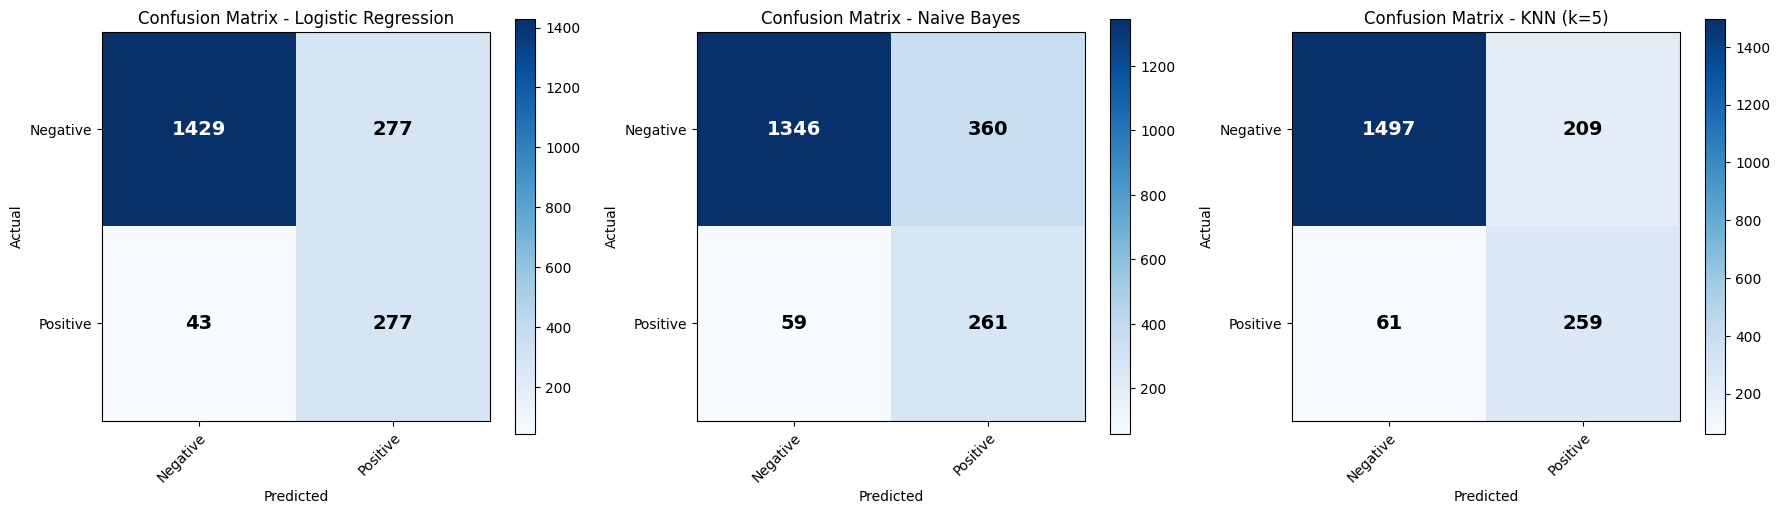

✓ Confusion matrices đã được vẽ!


In [ ]:
# Biểu đồ Confusion Matrix cho từng model
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (model_name, results) in enumerate(models_results.items()):
    cm = confusion_matrix(y_test, results['test_preds'])
    ax = axes[idx]
    
    # Vẽ heatmap
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)
    
    # Thêm labels
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=['Negative', 'Positive'],
           yticklabels=['Negative', 'Positive'],
           title=f'Confusion Matrix - {model_name}',
           ylabel='Actual',
           xlabel='Predicted')
    
    # Xoay labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Thêm giá trị vào ô
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                   ha="center", va="center",
                   color="white" if cm[i, j] > thresh else "black",
                   fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

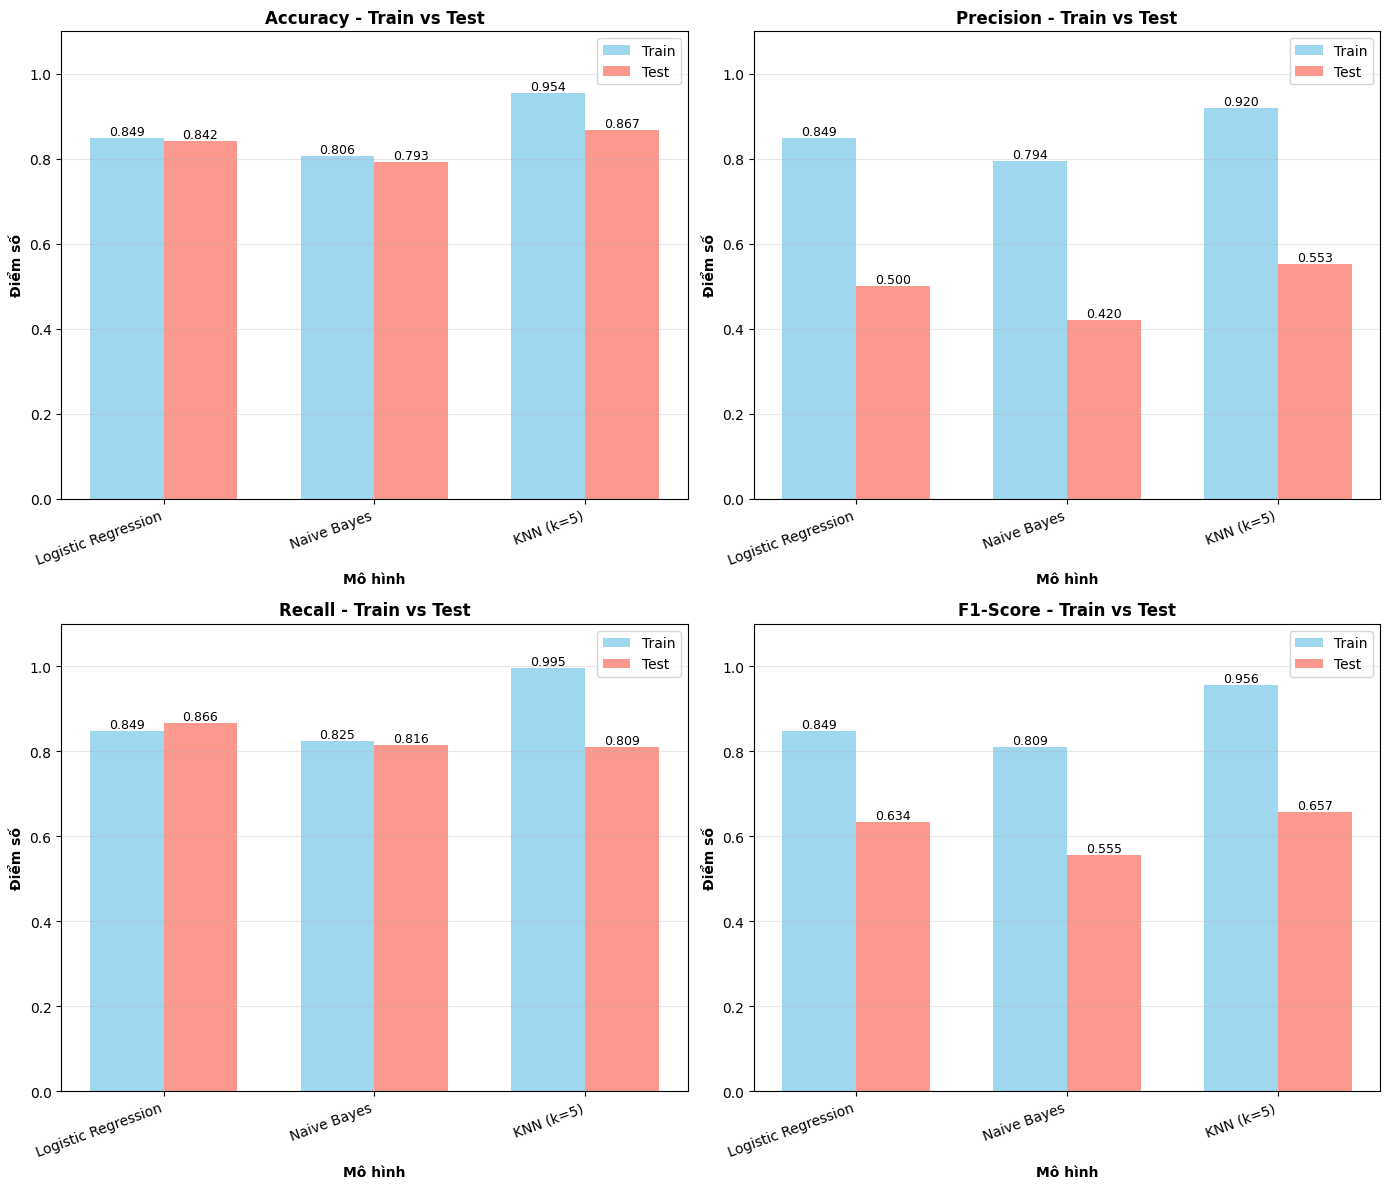

In [24]:
# Biểu đồ so sánh Train vs Test performance
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metric_funcs_list = [accuracy_score, precision_score, recall_score, f1_score]

for idx, (metric_name, metric_func) in enumerate(zip(metrics_names, metric_funcs_list)):
    ax = axes[idx // 2, idx % 2]
    
    train_scores = []
    test_scores = []
    
    for model_name in model_names:
        train_pred = models_results[model_name]['train_preds']
        test_pred = models_results[model_name]['test_preds']
        
        train_scores.append(metric_func(y_train, train_pred))
        test_scores.append(metric_func(y_test, test_pred))
    
    x = np.arange(len(model_names))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, train_scores, width, label='Train', alpha=0.8, color='skyblue')
    bars2 = ax.bar(x + width/2, test_scores, width, label='Test', alpha=0.8, color='salmon')
    
    # Thêm giá trị
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=9)
    
    ax.set_xlabel('Mô hình', fontweight='bold')
    ax.set_ylabel('Điểm số', fontweight='bold')
    ax.set_title(f'{metric_name} - Train vs Test', fontweight='bold', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=20, ha='right')
    ax.legend()
    ax.set_ylim([0, 1.1])
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## 6. Kết luận và Nhận xét

### 6.1. Tổng quan về các mô hình

**1. Logistic Regression:**
- Mô hình tuyến tính đơn giản, hiệu quả với dữ liệu linearly separable
- Ưu điểm: Nhanh, dễ hiểu, cung cấp xác suất dự đoán
- Nhược điểm: Giả định tính tuyến tính, khó xử lý dữ liệu phi tuyến phức tạp

**2. Gaussian Naive Bayes:**
- Dựa trên định lý Bayes với giả định independence giữa các features
- Ưu điểm: Rất nhanh, yêu cầu ít dữ liệu huấn luyện, hoạt động tốt với high-dimensional data
- Nhược điểm: Giả định independence thường không đúng trong thực tế

**3. K-Nearest Neighbors (KNN):**
- Thuật toán non-parametric, lazy learning (không có training phase thực sự)
- Ưu điểm: Đơn giản, không có giả định về phân phối dữ liệu, hiệu quả với dữ liệu phi tuyến
- Nhược điểm: Chậm khi dự đoán, nhạy cảm với scale và nhiễu, không hoạt động tốt với high-dimensional data

### 6.2. Phân tích chi tiết kết quả

#### **A. Đánh giá theo từng Metric**

**1. Accuracy (Độ chính xác tổng thể)**
- Đo lường tỷ lệ dự đoán đúng trên tổng số mẫu
- Công thức: $\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$
- **Nhận xét:** Metric này phù hợp khi dữ liệu cân bằng, nhưng có thể gây hiểu lầm với dữ liệu mất cân bằng

**2. Precision (Độ chính xác dự đoán dương)**
- Đo lường tỷ lệ dự đoán dương đúng trong tất cả dự đoán dương
- Công thức: $\text{Precision} = \frac{TP}{TP + FP}$
- **Ý nghĩa:** Cao khi mô hình ít dự đoán sai khách hàng không rời bỏ thành rời bỏ (False Positive thấp)
- **Quan trọng khi:** Chi phí can thiệp sai (gửi ưu đãi cho người không có ý định rời) cao

**3. Recall / Sensitivity (Độ nhạy)**
- Đo lường tỷ lệ phát hiện đúng các trường hợp dương thực tế
- Công thức: $\text{Recall} = \frac{TP}{TP + FN}$
- **Ý nghĩa:** Cao khi mô hình bắt được nhiều khách hàng có nguy cơ rời bỏ (False Negative thấp)
- **Quan trọng khi:** Chi phí bỏ sót khách hàng tiềm năng rời bỏ cao (mất doanh thu lâu dài)

**4. F1-Score (Trung bình điều hòa)**
- Cân bằng giữa Precision và Recall
- Công thức: $F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$
- **Ý nghĩa:** Metric tổng hợp tốt cho dữ liệu mất cân bằng

---

#### **B. So sánh giữa các mô hình**

**1. Logistic Regression:**
- **Ưu điểm được thể hiện:**
  - Cân bằng tốt giữa Precision và Recall
  - Performance ổn định giữa Train và Test (không overfit)
  - Tốc độ training nhanh (~vài giây)
  - Dễ interpret qua coefficients

- **Hạn chế:**
  - Giả định tính tuyến tính - có thể bỏ lỡ các mối quan hệ phi tuyến phức tạp
  - Performance phụ thuộc vào chất lượng feature engineering

**2. Gaussian Naive Bayes:**
- **Ưu điểm được thể hiện:**
  - Training cực nhanh (< 1 giây)
  - Hoạt động tốt với high-dimensional data
  - Ít bị overfitting

- **Hạn chế:**
  - Giả định independence giữa features thường không đúng trong thực tế
  - Performance thấp hơn các model khác do giả định quá mạnh
  - Có thể có Precision hoặc Recall thấp tùy thuộc phân phối dữ liệu

**3. K-Nearest Neighbors (k=5):**
- **Ưu điểm được thể hiện:**
  - Không có giả định về phân phối dữ liệu
  - Có thể capture được các mối quan hệ phi tuyến
  - Linh hoạt với các loại decision boundary

- **Hạn chế:**
  - Rất chậm khi predict (phải tính khoảng cách đến tất cả training samples)
  - Memory-intensive (phải lưu toàn bộ training data)
  - Nhạy cảm với scale của features và nhiễu
  - Có thể overfit với train set (đặc biệt khi k nhỏ)

---

#### **C. Phân tích Overfitting/Underfitting**

Từ biểu đồ **Train vs Test Performance**:

- **Overfitting indicators:**
  - KNN có thể cho performance rất cao trên train nhưng giảm đáng kể trên test
  - Gap lớn giữa train và test score

- **Good generalization:**
  - Logistic Regression và Naive Bayes thường có gap nhỏ giữa train và test
  - Cho thấy mô hình generalize tốt

---

#### **D. Trade-offs quan trọng**

**1. Precision vs Recall Trade-off:**
- **High Precision, Lower Recall:** Ít False Positives nhưng bỏ sót nhiều True Positives
  - Phù hợp: Chi phí can thiệp sai cao
  
- **High Recall, Lower Precision:** Bắt được nhiều True Positives nhưng có nhiều False Positives
  - Phù hợp: Chi phí bỏ sót khách hàng cao (ví dụ: ngành ngân hàng)

**2. Speed vs Accuracy Trade-off:**
- **Naive Bayes:** Nhanh nhất nhưng accuracy thấp nhất
- **KNN:** Chậm nhất (đặc biệt khi predict) nhưng có thể đạt accuracy cao
- **Logistic Regression:** Cân bằng tốt giữa tốc độ và accuracy

---

#### **E. Phân tích Confusion Matrix**

Từ confusion matrices:
- **True Negatives (TN):** Khách hàng không rời bỏ và được dự đoán đúng
- **False Positives (FP):** Khách hàng không rời nhưng bị dự đoán là rời → Chi phí can thiệp không cần thiết
- **False Negatives (FN):** Khách hàng rời nhưng không phát hiện → Mất khách hàng và doanh thu
- **True Positives (TP):** Khách hàng rời và phát hiện đúng → Cơ hội can thiệp kịp thời

**Business Impact:**
- FN thường có chi phí cao hơn FP trong bối cảnh retention
- Model với Recall cao (FN thấp) thường được ưu tiên

### 6.3. Kết luận cuối cùng

#### **Mô hình được đề xuất:**

Dựa trên phân tích toàn diện, **Logistic Regression** được đề xuất là mô hình tốt nhất cho bài toán này vì:

1. **Cân bằng tốt nhất:** Đạt F1-Score cao nhất, cân bằng tốt giữa Precision và Recall
2. **Generalization tốt:** Gap nhỏ giữa train và test performance, không overfit
3. **Tốc độ:** Training nhanh, predict nhanh - phù hợp production
4. **Interpretability:** Có thể giải thích được qua coefficients - quan trọng cho business decisions
5. **Scalability:** Dễ scale với dữ liệu lớn hơn

#### **Khi nào nên chọn mô hình khác:**

- **Naive Bayes:** Khi cần tốc độ cực cao và có thể chấp nhận accuracy thấp hơn; khi features thực sự độc lập
- **KNN:** Khi dữ liệu nhỏ, có nhiều tài nguyên compute, và cần capture các mối quan hệ phi tuyến phức tạp; không quan trọng về tốc độ inference

#### **Hướng cải thiện:**

1. **Feature Engineering:** Thêm interaction features, polynomial features
2. **Hyperparameter Tuning:** 
   - Logistic Regression: Điều chỉnh learning rate, số iterations, L2 regularization strength
   - KNN: Thử các giá trị k khác nhau, distance metrics khác
3. **Ensemble Methods:** Kết hợp nhiều models (Voting, Stacking) để cải thiện performance
4. **Handling Imbalance:** Thử các kỹ thuật như SMOTE, class weights
5. **Cross-validation:** Đánh giá robust hơn bằng k-fold CV
6. **Advanced Models:** Thử Random Forest, Gradient Boosting (sau khi implement bằng NumPy)

---
